# OpenAI Gym: Deep Q-Learning

Let's see whether the technique used for Q-Learning scale to Deep Q-Learning just by swapping the table with a deep network. For our tests we use [CartPole](https://www.gymlibrary.ml/environments/classic_control/cart_pole/), the easier among the [Classic control](https://www.gymlibrary.ml/environments/classic_control/) environments.

In [1]:
import gym
import numpy as np

from qlearn import plot_rewards, basic_training, run_episode, QTable

First we create a new enviroment, we can use the `render` method to show the state:

In [2]:
gym_env = gym.make('CartPole-v1')

We can use a random agent to get the baseline for our work:

<Axes: xlabel='Episode', ylabel='Total Reward'>

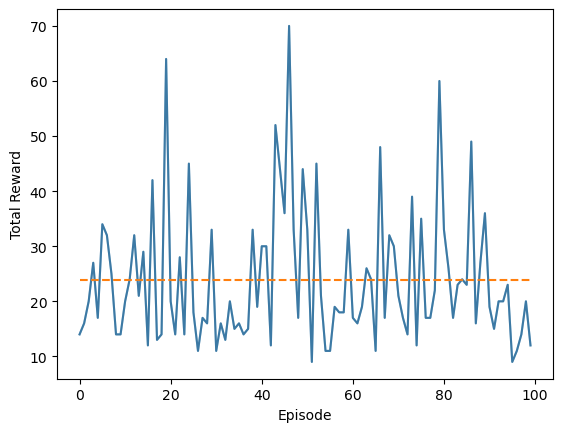

In [3]:
plot_rewards([run_episode(gym_env).reward for _ in range(100)])

We can try to use the `basic_training` function, so we need to create a `QTable` class using a *pytorch* model.

First we define a class for the sequential deep network:

In [4]:
import torch
import torch.nn as nn

@torch.no_grad()
def init_weights(m: nn.Module):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

class DQNet(nn.Module):

    def __init__(self, obs_size, action_size):
        super(DQNet, self).__init__()
        self._block = nn.Sequential(
            nn.Linear(in_features=obs_size, out_features=24),
            nn.ReLU(),
            nn.Linear(in_features=24, out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12, out_features=action_size)
        )
        self._block.apply(init_weights)

    def forward(self, x):
        return self._block(x)


Then we subclass `QTable` using the above defined network

In [5]:
class DeepQTableSeq(QTable):
    """Q-table using a sequential deep network. Requires discrete action spaces and observation spaces supporting the shape method (Numpy ndarray)."""
    def __init__(self, env: gym.Env, learning_rate: float=0.001, loss_fn=None, optimiser=None):
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._model = DQNet(env.observation_space.shape[0], env.action_space.n).to(self._device)
        self._loss_fn = nn.HuberLoss() if loss_fn is None else loss_fn
        self._optimiser = torch.optim.Adam(params=self._model.parameters(), lr=learning_rate) if optimiser is None else optimiser

    @property
    def model(self) -> DQNet:
        return self._model

    def fit(self, observations: np.ndarray, target_values: np.ndarray):
        batch_size = len(observations)
        assert batch_size == len(target_values), f'Size of observations ({batch_size}) and target values ({len(target_values)}) don\'t match'

        for X, y in zip((torch.tensor(x) for x in observations), (torch.tensor(y) for y in target_values)):
            # Compute prediction and loss
            pred = self.model(X)
            loss = self._loss_fn(pred, y)

            # Backpropagation
            self._optimiser.zero_grad()
            loss.backward()
            self._optimiser.step()

    def copy(self, source: 'DeepQTableSeq'):
        self.model.load_state_dict(source.model.state_dict())

    def predict(self, observations: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            return self.model(torch.tensor(observations)).numpy()

    def values(self, observation: np.ndarray) -> np.ndarray:
        return self.predict(observation.reshape([1, observation.shape[0]]))[0]

    def policy(self, observation: np.ndarray) -> int:
        values = self.values(observation)
        v_max = np.max(values)
        return np.random.choice(np.where(values == v_max)[0])

    def expected(self, obs: np.ndarray, action: int = None) -> float:
        values = self.values(obs)
        if action is None:
            return np.max(values)
        else:
            return values[action]

    def update(self, obs: np.ndarray, action: int, value: float) -> None:
        targets = self.values(obs)
        targets[action] = value
        self.fit(np.array([obs]), np.array([targets]))


Let's create a table and see how it compares with the random agent before the training

Average reward: 79.79


<Axes: xlabel='Episode', ylabel='Total Reward'>

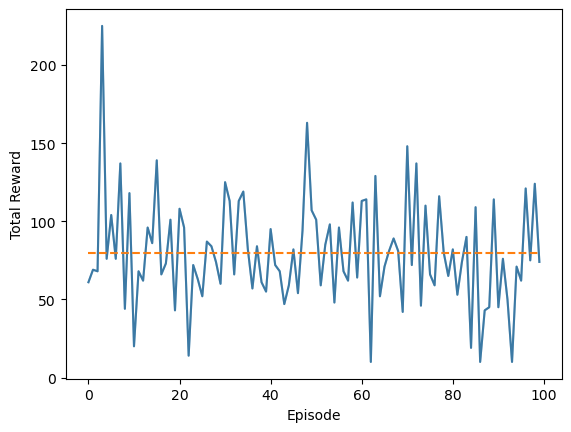

In [6]:
qtable = DeepQTableSeq(gym_env)

rewards = [run_episode(gym_env, qtable=qtable).reward for _ in range(100)]
print('Average reward: {}'.format(np.mean((rewards))))

plot_rewards(rewards)

Now we train our agent to learn the Q-table and have a look at rewards:

<Axes: xlabel='Episode', ylabel='Total Reward'>

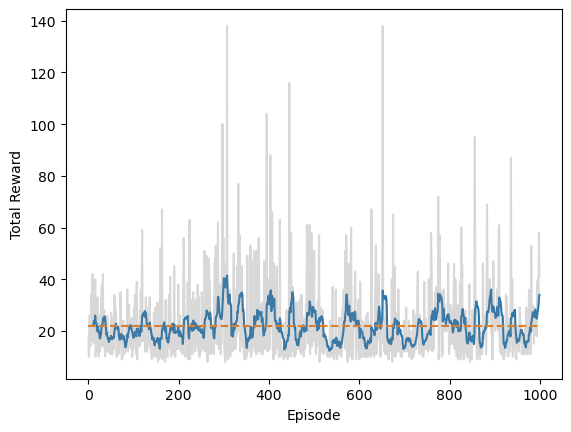

In [7]:
plot_rewards(basic_training(gym_env, qtable, 1000, alpha=0.8, gamma=0.6, epsilon=0.9, epsilon_decay=0.001))


Let's see whether is better than before

Average reward: 43.85


<Axes: xlabel='Episode', ylabel='Total Reward'>

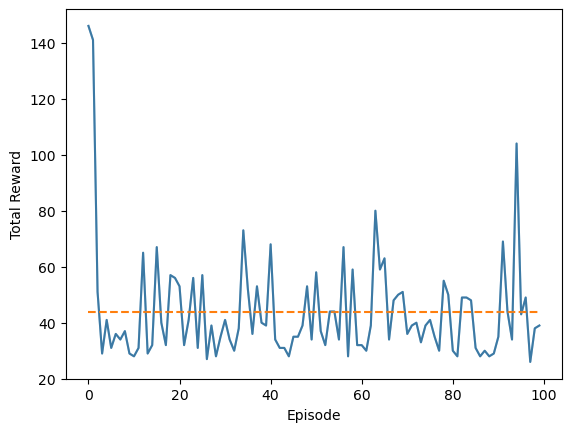

In [8]:
rewards = [run_episode(gym_env, qtable=qtable).reward for _ in range(100)]
print('Average reward: {}'.format(np.mean((rewards))))

plot_rewards(rewards)

Unfortunately, modulo randomisation, you should get results that might be even worse than the random baseline. Note that from the training rewards plot it seems that the model is learning, however it is not converging.

## How to improve the learning process?

There are several techniques that can be applied to the basic training to improve the results:

- *Batch replay*: instead of updating the model at each step, store observations on a buffer and every $N$ steps draw a random sample from the buffer to train the model. This helps in reducing the drift due to the similarity of temporally close observations.
- *Skip bad episodes*: avoid learning from bad episodes by throwing away observations coming from episodes with an outcome lower by a (variable) threshold.
- *Double DQN*: use two identical models: one to be updated and the other for the estimation of the Q-Table. Every $N'$ steps the weights of the first model are copied to the second.